## Flight Delay Prediction  

Overhauled and changed into a regressor from: https://www.kaggle.com/code/gcdatkin/flight-cancellation-prediction/notebook

This is a wide re-jigging of the code and models into one which can accurately predict the duration of the departure delay (analogous to arrival delay) and whether there is a delay at all based on the input features.

The original and other notebooks floating around have focused on the mathematical presence of a delay (any departure > scheduled departure time) that can lead to some seriously high accuracies that do not adequately inform a perspective on airline delays. Delays of concern are only greater than 15+ mins according to the FAA, and the scale of each delay varies widely to the point of extreme difference between a 20 minute delay and a 3 hour delay. If we consider the outcomes for an airline or airport when it comes to delays, every minute is of interest. A model that accurately predicts whether a flight will experience a mean 15 minute delay is not nearly as useful as one that can predict a delay at 20 minutes, as this is when penalties and claims may kick in. Further, predicting the scale of the delay based on the input information is enormously helpful in determining what resources should be allocated to a delay response.

As such, this notebook is split into two sections, regression and classification, each addressing a different hypothetical business case for what to predict. The results show that predicting the magnitude of a delay is much easier than predicting whether a delay will occur at all. Decision Trees are used for all models as both regressors and classifiers, with minimal tuning on depth. Decision Trees are a versatile and highly interpretable classifier, whose features are extremely suitable to this proposed case.

![Vintage airport](https://blogger.googleusercontent.com/img/a/AVvXsEhRD86JOT6rVfsZsfdVXFT0SeLGp27_Fc0xOm-m5xubrtdv9WwwiB3dYmD-zNsMZvAE7TNDtnMHyilkKyx99peeRn5FLd-ZdqQu96jbhL8DqdkOb5giKfCH4KDqZEH-wtd9cKcjGrQu8THnTGXsMICZxwO11uCNGtjAwhsU32yfp_n67s6AcctdLUWC9g=w640-h406)

# <a id='0'>Content</a>

- <a href='#1'>Load and Explore</a>  
- <a href='#2'>Pre-processing</a>   
- <a href='#3'>Regressors</a>   
- <a href='#4'>Classifiers</a>   
- <a href='#5'>Extra: Comparison</a>   

# <a id='1'>Load and Explore</a>  

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model

import graphviz
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data = pd.read_csv('../input/flight-delays/flights.csv', nrows=50000)

In [3]:
data

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2015,1,4,7,AA,1524,N499AA,DFW,LAS,915,...,1010.0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
49996,2015,1,4,7,AA,2316,N3FNAA,STX,MIA,915,...,1126.0,4.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
49997,2015,1,4,7,AS,5,N566AS,DCA,LAX,915,...,1247.0,37.0,0,0,NaN,37.0,0.0,0.0,0.0,0.0
49998,2015,1,4,7,DL,688,N893AT,ATL,ICT,915,...,1037.0,-3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 50000 non-null  int64  
 1   MONTH                50000 non-null  int64  
 2   DAY                  50000 non-null  int64  
 3   DAY_OF_WEEK          50000 non-null  int64  
 4   AIRLINE              50000 non-null  object 
 5   FLIGHT_NUMBER        50000 non-null  int64  
 6   TAIL_NUMBER          49941 non-null  object 
 7   ORIGIN_AIRPORT       50000 non-null  object 
 8   DESTINATION_AIRPORT  50000 non-null  object 
 9   SCHEDULED_DEPARTURE  50000 non-null  int64  
 10  DEPARTURE_TIME       48896 non-null  float64
 11  DEPARTURE_DELAY      48896 non-null  float64
 12  TAXI_OUT             48873 non-null  float64
 13  WHEELS_OFF           48873 non-null  float64
 14  SCHEDULED_TIME       50000 non-null  int64  
 15  ELAPSED_TIME         48753 non-null 

In [5]:
#Checking for unique aircraft - most aircraft are unique in this dataset, so we cannot find repeat offenders for delays
tails = data.groupby('TAIL_NUMBER')
tails.head(10)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49977,2015,1,4,7,US,1806,N190UW,LAX,CLT,915,...,1712.0,26.0,0,0,NaN,4.0,0.0,22.0,0.0,0.0
49979,2015,1,4,7,VX,500,N642VA,FLL,JFK,915,...,1158.0,3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
49992,2015,1,4,7,AA,1196,N5CRAA,MIA,EGE,915,...,1242.0,44.0,0,0,NaN,9.0,0.0,33.0,2.0,0.0
49996,2015,1,4,7,AA,2316,N3FNAA,STX,MIA,915,...,1126.0,4.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#Only 140 airlines, so we can use this variable to predict delays once encoded
airlines = data.groupby('AIRLINE')
airlines.head(10)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,2015,1,1,4,VX,474,N525VA,LAX,LAS,750,...,844.0,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1564,2015,1,1,4,VX,1493,N855VA,LAS,LAX,800,...,904.0,-6.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1565,2015,1,1,4,VX,174,N624VA,SFO,EWR,800,...,1559.0,-31.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1566,2015,1,1,4,VX,1930,N838VA,SFO,LAX,800,...,914.0,-6.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#Only 140 airlines, so we can use this variable to predict delays once encoded
airlines = data.groupby('AIRLINE')
airlines.head(10)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,2015,1,1,4,VX,474,N525VA,LAX,LAS,750,...,844.0,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1564,2015,1,1,4,VX,1493,N855VA,LAS,LAX,800,...,904.0,-6.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1565,2015,1,1,4,VX,174,N624VA,SFO,EWR,800,...,1559.0,-31.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1566,2015,1,1,4,VX,1930,N838VA,SFO,LAX,800,...,914.0,-6.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 50000 non-null  int64  
 1   MONTH                50000 non-null  int64  
 2   DAY                  50000 non-null  int64  
 3   DAY_OF_WEEK          50000 non-null  int64  
 4   AIRLINE              50000 non-null  object 
 5   FLIGHT_NUMBER        50000 non-null  int64  
 6   TAIL_NUMBER          49941 non-null  object 
 7   ORIGIN_AIRPORT       50000 non-null  object 
 8   DESTINATION_AIRPORT  50000 non-null  object 
 9   SCHEDULED_DEPARTURE  50000 non-null  int64  
 10  DEPARTURE_TIME       48896 non-null  float64
 11  DEPARTURE_DELAY      48896 non-null  float64
 12  TAXI_OUT             48873 non-null  float64
 13  WHEELS_OFF           48873 non-null  float64
 14  SCHEDULED_TIME       50000 non-null  int64  
 15  ELAPSED_TIME         48753 non-null 

# <a id='2'>Pre-processing</a>  

### Arranging rows and columns
Features with low interpretability or a high chance of heteroskedasticity are removed, before conducting a rudimentary correlation heatmap to check before and after

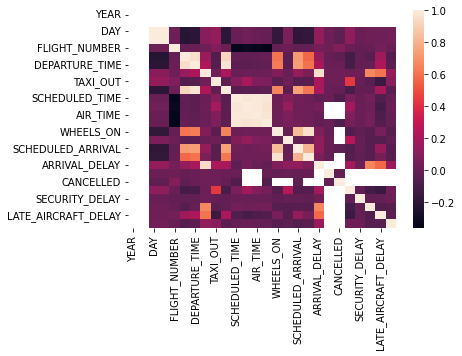

In [9]:
sns.heatmap(data.corr());

The multiple similar delay timings make this difficult to read - cutting down to a few distinct features will help in understanding the final result. For example, we can remove the year variable given the feature would not be helpful in predicting future results, while the month variable would - it remains our best proxy for overall weather conditions.

There are two delays to investigate, a departure delay and an arrival delay. We need to select one to regress and predict. 

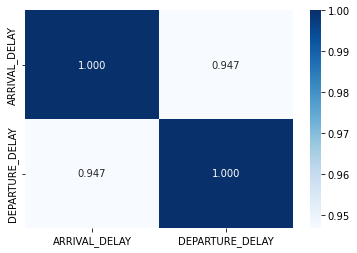

In [10]:
sns.heatmap(data[['ARRIVAL_DELAY','DEPARTURE_DELAY']].corr(), annot=True, cmap='Blues',fmt='.3f');

Wayyy too high correlation between departure delay and arrival delay. Intuitively we know this relationship is sequential, where departure must come before arrival. Therefore, we can only adequately estimate departure delay, and assume a carry-on to departure delay for around 93% of examples.

In [11]:
# Departure delay checking for outliers
data['DEPARTURE_DELAY'].max()

1380.0

In [12]:
data['DEPARTURE_DELAY'].mean()

15.59602012434555

In [13]:
#Very large delays will affect our model significantly since our scale has no negative balance
data.nlargest(10, ['DEPARTURE_DELAY'])

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
35353,2015,1,3,6,AA,1677,N557AA,MEM,DFW,1010,...,1054.0,1384.0,0,0,NaN,4.0,0.0,1380.0,0.0,0.0
6371,2015,1,1,4,AA,2470,N5CAAA,BOS,DFW,1315,...,1246.0,1201.0,0,0,NaN,11.0,0.0,1169.0,21.0,0.0
32383,2015,1,3,6,AA,2281,N558AA,IND,DFW,705,...,30.0,950.0,0,0,NaN,1.0,0.0,58.0,891.0,0.0
39834,2015,1,3,6,DL,401,N722TW,SJU,JFK,1457,...,939.0,934.0,0,0,NaN,18.0,0.0,916.0,0.0,0.0
22654,2015,1,2,5,DL,1743,N994DL,ECP,ATL,1349,...,702.0,902.0,0,0,NaN,0.0,0.0,902.0,0.0,0.0
41698,2015,1,3,6,AA,291,N3GYAA,JFK,AUS,1700,...,1103.0,883.0,0,0,NaN,0.0,0.0,695.0,188.0,0.0
42171,2015,1,3,6,AA,45,N3EGAA,JFK,LAS,1729,...,1132.0,908.0,0,0,NaN,22.0,0.0,547.0,339.0,0.0
28381,2015,1,2,5,AA,1302,N434AA,RDU,DFW,1930,...,1228.0,888.0,0,0,NaN,3.0,0.0,542.0,343.0,0.0
48740,2015,1,4,7,OO,3499,N225AG,SLC,PDX,800,...,2347.0,892.0,0,0,NaN,9.0,0.0,883.0,0.0,0.0
13858,2015,1,1,4,DL,1840,N549US,LIH,LAX,2319,...,2051.0,847.0,0,0,NaN,0.0,0.0,847.0,0.0,0.0


The FAA considers flights delayed by more than 15  minutes (https://en.wikipedia.org/wiki/Flight_cancellation_and_delay) as delayed, which is conveniently our mean. This means we can drop values below 15 minutes and focus on longer delays of concern to airports.

In [14]:
df_pp = data.copy()
df_pp = df_pp[df_pp.DEPARTURE_DELAY > 15]

Next, clear out the columns and retain those we want for analysis, including remove NaN values

In [15]:
# Remove columns with more than 25% missing values
missing_columns = df_pp.loc[:, df_pp.isna().mean() >= 0.25].columns
df_pp = df_pp.drop(missing_columns, axis=1)


# We will not consider cancelled or diverted flights as cancellation, diversion and delay should be exclusive
df_pp = df_pp[df_pp.CANCELLED != 1]
df_pp = df_pp[df_pp.DIVERTED != 1]

# Drop all columns that do not add interpretability to the model
df_pp = df_pp.drop(['YEAR','DAY','FLIGHT_NUMBER', 'TAIL_NUMBER','TAXI_OUT','SCHEDULED_DEPARTURE','WHEELS_OFF',
                  'WHEELS_ON','TAXI_IN','SCHEDULED_ARRIVAL','DIVERTED','CANCELLED'], axis=1)
    
# Fill NaNs
df_pp = df_pp.fillna(0)

df_pp.head(30)

,MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
20,1,4,NK,LAS,MCI,120.0,25.0,162,143.0,128.0,1139,543.0,6.0,0.0,0.0,0.0,0.0,0.0
29,1,4,AA,DEN,MIA,141.0,21.0,227,208.0,188.0,1709,709.0,2.0,0.0,0.0,0.0,0.0,0.0
30,1,4,NK,PHX,ORD,237.0,72.0,204,175.0,156.0,1440,632.0,43.0,43.0,0.0,0.0,0.0,0.0
52,1,4,B6,SJU,MCO,535.0,95.0,185,175.0,163.0,1189,730.0,85.0,0.0,0.0,85.0,0.0,0.0
55,1,4,B6,SJU,BDL,550.0,72.0,241,258.0,237.0,1666,908.0,89.0,17.0,0.0,72.0,0.0,0.0
70,1,4,AA,DFW,MIA,703.0,108.0,161,155.0,133.0,1121,1038.0,102.0,0.0,0.0,0.0,0.0,102.0
73,1,4,US,PDX,PHX,620.0,60.0,150,150.0,132.0,1009,950.0,60.0,0.0,0.0,60.0,0.0,0.0
74,1,4,AA,IAH,MIA,618.0,58.0,141,137.0,111.0,964,935.0,54.0,0.0,0.0,54.0,0.0,0.0
86,1,4,AA,DEN,DFW,623.0,53.0,125,138.0,96.0,641,941.0,66.0,13.0,0.0,53.0,0.0,0.0
92,1,4,UA,SFO,DEN,550.0,19.0,146,153.0,127.0,967,923.0,26.0,7.0,0.0,19.0,0.0,0.0


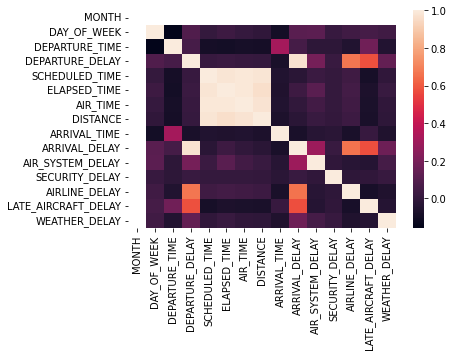

In [16]:
sns.heatmap(df_pp.corr());

Arrival delay, unsurprisingly, appears most correlated with departure delay. We will need to one-hot encode the non-numeric variables to find a better explanation.

In [17]:
df_pp = df_pp.drop(['ARRIVAL_DELAY'], axis=1)

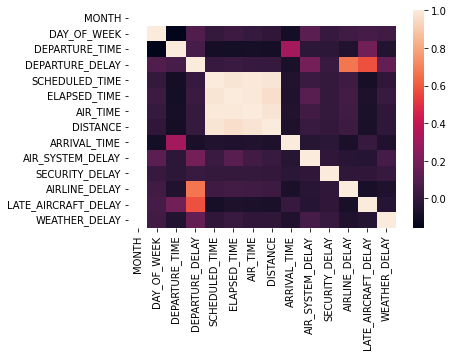

In [18]:
sns.heatmap(df_pp.corr());

### Encoding

In [19]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

In [20]:
features_to_encode = ['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT']

df_pp_enc = encode_and_bind(df_pp, features_to_encode[0])
df_pp_enc = encode_and_bind(df_pp_enc, features_to_encode[1])
df_pp_enc = encode_and_bind(df_pp_enc, features_to_encode[2])

df_pp_enc.head()

,MONTH,DAY_OF_WEEK,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,ARRIVAL_TIME,AIR_SYSTEM_DELAY,...,DESTINATION_AIRPORT_TYR,DESTINATION_AIRPORT_TYS,DESTINATION_AIRPORT_UST,DESTINATION_AIRPORT_VEL,DESTINATION_AIRPORT_VLD,DESTINATION_AIRPORT_VPS,DESTINATION_AIRPORT_WRG,DESTINATION_AIRPORT_XNA,DESTINATION_AIRPORT_YAK,DESTINATION_AIRPORT_YUM
20,1,4,120.0,25.0,162,143.0,128.0,1139,543.0,0.0,...,0,0,0,0,0,0,0,0,0,0
29,1,4,141.0,21.0,227,208.0,188.0,1709,709.0,0.0,...,0,0,0,0,0,0,0,0,0,0
30,1,4,237.0,72.0,204,175.0,156.0,1440,632.0,43.0,...,0,0,0,0,0,0,0,0,0,0
52,1,4,535.0,95.0,185,175.0,163.0,1189,730.0,0.0,...,0,0,0,0,0,0,0,0,0,0
55,1,4,550.0,72.0,241,258.0,237.0,1666,908.0,17.0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
y = df_pp_enc['DEPARTURE_DELAY'].copy()
X = df_pp_enc.drop('DEPARTURE_DELAY', axis=1).copy()

### Train-Test Split

In [22]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=369)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, random_state=369)

#No need for scaling as we are regressing

# <a id='3'>Regressors</a>  

In [23]:
lm = LinearRegression()
L_model = lm.fit(X_train,y_train)
L_predictions = pd.DataFrame(lm.predict(X_valid))
print(L_predictions.head(50))
print("MSE =", metrics.mean_squared_error(L_predictions, y_valid))

             0
0    13.112851
1    29.485386
2    48.550035
3    31.671105
4     6.179131
5    29.987292
6    15.032706
7    63.943693
8   127.038586
9    17.984934
10   57.028585
11   64.380957
12   19.921646
13  190.278867
14   33.078380
15   82.417923
16   38.430398
17   35.907206
18   27.693945
19   50.426825
20   28.083703
21   25.790672
22   45.186941
23   19.359687
24   50.090352
25   20.484770
26   95.235505
27    8.100161
28   75.960126
29   25.722188
30   59.130588
31   82.823052
32   73.330925
33   71.843975
34   19.405086
35   76.104271
36   45.499402
37  106.809139
38   21.140053
39   28.049947
40   57.173615
41   24.771492
42   19.351298
43  327.157505
44   34.335148
45   56.391602
46   42.960666
47   76.150662
48   19.593132
49   26.600794
MSE = 12.218961326454341


In [24]:
DT_regr = DecisionTreeRegressor(max_depth=3, random_state=369)
DT_model = DT_regr.fit(X_train,y_train)
DT_predictions = pd.DataFrame(DT_regr.predict(X_valid))
print(DT_predictions.head(50))
print("MSE =", metrics.mean_squared_error(DT_predictions, y_valid))

             0
0    39.581372
1    39.581372
2    39.581372
3    39.581372
4    39.581372
5    39.581372
6    39.581372
7    77.256680
8   150.845209
9    39.581372
10   77.256680
11   77.256680
12   39.581372
13  150.845209
14   39.581372
15   39.581372
16   39.581372
17   39.581372
18   39.581372
19   39.581372
20   39.581372
21   39.581372
22   39.581372
23   39.581372
24   39.581372
25   39.581372
26   77.256680
27   39.581372
28   77.256680
29   39.581372
30   39.581372
31   39.581372
32   39.581372
33   77.256680
34   39.581372
35   77.256680
36   39.581372
37  150.845209
38   39.581372
39   39.581372
40   77.256680
41   39.581372
42   39.581372
43  266.666667
44   39.581372
45   39.581372
46   39.581372
47   77.256680
48   39.581372
49   39.581372
MSE = 1012.857883165995


# Results

In [25]:
DT_accuracy = DT_model.score(X_valid, y_valid)
print('DT Accuracy = '+ str(DT_accuracy.round(2)))

DT Accuracy = 0.71


The DT classifier has a viable accuracy score, while linear regression is beyond salvage. The high MSE and low accuracy is likely caused by the huge spread of data contained in our delay variable.

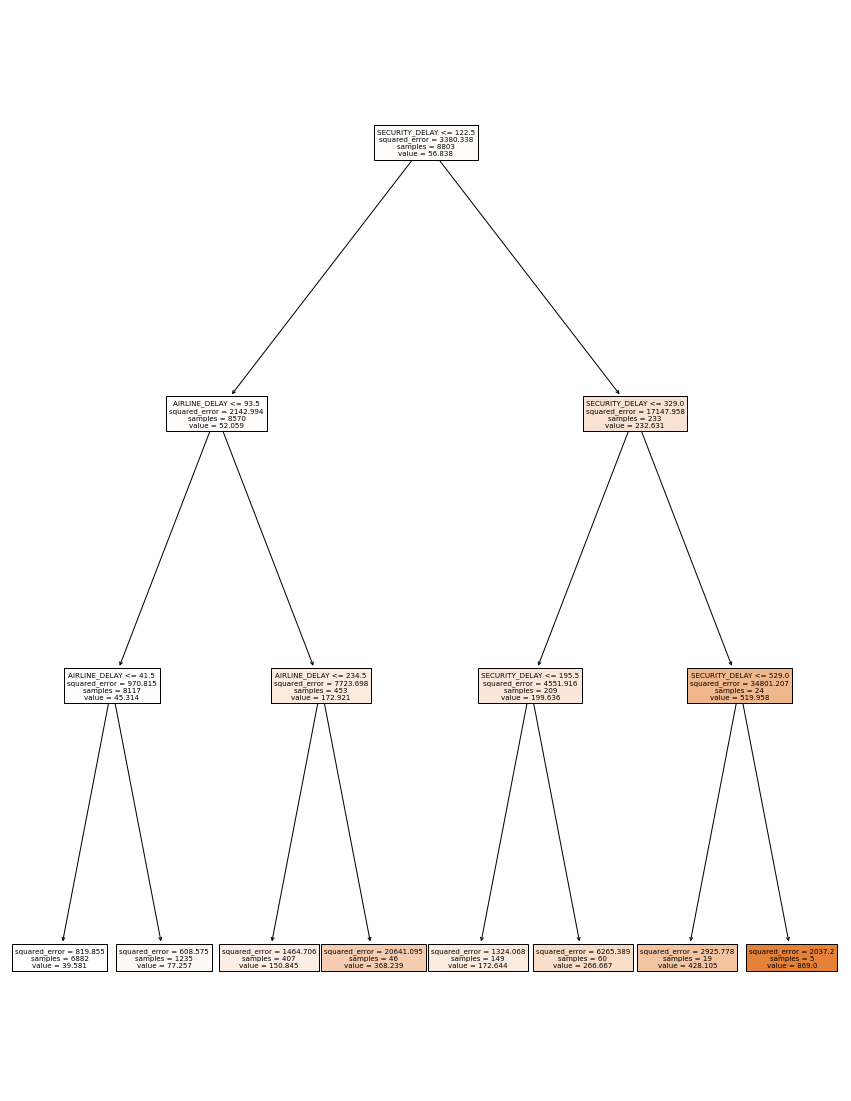

In [26]:
fig = plt.figure(figsize=(15,20))
_ = tree.plot_tree(DT_regr, feature_names=df_pp_enc.columns, filled=True)

This decision tree is barely interpretable, but still good enough for a very low max depth. We can then move onto the final model using a method to find the best max depth of the trees.

![An interesting tree](http://images4.fanpop.com/image/photos/18500000/2x08-Raging-Bender-futurama-18556519-720-540.jpg)

## Optimizing Decision Tree Depth

Text(0.5, 0, 'max depth')

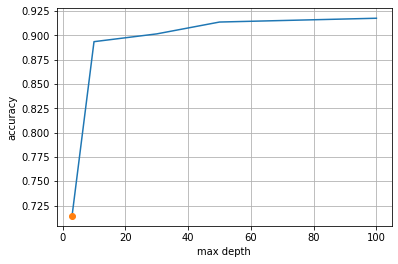

In [27]:
from sklearn.metrics import accuracy_score
max_depth_list = [3,10,30,50,100]

accuracy = []

for x in max_depth_list:
    dtc = DecisionTreeRegressor(max_depth=x) 
    dtc.fit(X_train, y_train)
    accuracy.append(dtc.score(X_valid, y_valid))

plt.plot(max_depth_list, accuracy) 
plt.plot(max_depth_list[0], accuracy[0], marker='o') 
plt.grid() #adds a grid to the plot
plt.ylabel('accuracy') #xlabel
plt.xlabel('max depth') #ylabel

The graph appears to suggest that more depth will provide a better result, so we can level out complexity and performance at a depth = 10. We then pass this parameter into the final model and evaluate on the test set:

In [28]:
DT_regr = DecisionTreeRegressor(max_depth=100, random_state=369)
DT_model = DT_regr.fit(X_train,y_train)
DT_predictions = pd.DataFrame(DT_regr.predict(X_test))
print("MSE =", metrics.mean_squared_error(DT_predictions, y_test))
DT_accuracy = DT_model.score(X_test, y_test)
print('DT Accuracy on Test Set = '+ str(DT_accuracy.round(2)))

MSE = 201.68702290076337
DT Accuracy on Test Set = 0.94


![A high accuracy demands acknowledgement](http://starklightpress.com/wp-content/uploads/2018/12/bender-applause.jpeg)

# <a id='4'>Classifiers</a>  

While the regressor is able to accurately predict a delay, this is most likely due to the high correlation seen in the heatmap between airport delays (at point of departure) and a departure delay. Since the departure delay is invariably a product of these factors, it would be better to find a classifier that can predict a delay greater than 15 minutes, so we can build a classifier for this scenario also.

For preprocessing the same encoded dataset we resplit, reorganize and then preprocess our data for classification, including scaling data for the numerical attributes.

In [29]:
#Re-pre-processing
df_pp = data.copy()

#Create new classifier
df_pp['DELAY'] = [1 if x > 15 else 0 for x in df_pp['DEPARTURE_DELAY']]

# Remove columns with more than 25% missing values
missing_columns = df_pp.loc[:, df_pp.isna().mean() >= 0.25].columns
df_pp = df_pp.drop(missing_columns, axis=1)


# We will not consider cancelled or diverted flights as cancellation, diversion and delay should be exclusive
df_pp = df_pp[df_pp.CANCELLED != 1]
df_pp = df_pp[df_pp.DIVERTED != 1]

# Drop all columns that do not add interpretability to the model
df_pp = df_pp.drop(['YEAR','DAY','FLIGHT_NUMBER', 'TAIL_NUMBER','TAXI_OUT','SCHEDULED_DEPARTURE','WHEELS_OFF',
                  'WHEELS_ON','TAXI_IN','SCHEDULED_ARRIVAL','DIVERTED','CANCELLED','ARRIVAL_DELAY','DEPARTURE_DELAY'], axis=1)
    
# Fill NaNs
df_pp = df_pp.fillna(0)

df_pp.head(30)

,MONTH,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_TIME,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,ARRIVAL_TIME,DELAY
0,1,4,AS,ANC,SEA,2354.0,205,194.0,169.0,1448,408.0,0
1,1,4,AA,LAX,PBI,2.0,280,279.0,263.0,2330,741.0,0
2,1,4,US,SFO,CLT,18.0,286,293.0,266.0,2296,811.0,0
3,1,4,AA,LAX,MIA,15.0,285,281.0,258.0,2342,756.0,0
4,1,4,AS,SEA,ANC,24.0,235,215.0,199.0,1448,259.0,0
5,1,4,DL,SFO,MSP,20.0,217,230.0,206.0,1589,610.0,0
6,1,4,NK,LAS,MSP,19.0,181,170.0,154.0,1299,509.0,0
7,1,4,US,LAX,CLT,44.0,273,249.0,228.0,2125,753.0,0
8,1,4,AA,SFO,DFW,19.0,195,193.0,173.0,1464,532.0,0
9,1,4,DL,LAS,ATL,33.0,221,203.0,186.0,1747,656.0,0


In [30]:
# Re-encode
features_to_encode = ['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT']

df_pp_enc = encode_and_bind(df_pp, features_to_encode[0])
df_pp_enc = encode_and_bind(df_pp_enc, features_to_encode[1])
df_pp_enc = encode_and_bind(df_pp_enc, features_to_encode[2])

df_pp_enc.head()

,MONTH,DAY_OF_WEEK,DEPARTURE_TIME,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,ARRIVAL_TIME,DELAY,AIRLINE_AA,...,DESTINATION_AIRPORT_TYR,DESTINATION_AIRPORT_TYS,DESTINATION_AIRPORT_UST,DESTINATION_AIRPORT_VEL,DESTINATION_AIRPORT_VLD,DESTINATION_AIRPORT_VPS,DESTINATION_AIRPORT_WRG,DESTINATION_AIRPORT_XNA,DESTINATION_AIRPORT_YAK,DESTINATION_AIRPORT_YUM
0,1,4,2354.0,205,194.0,169.0,1448,408.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,4,2.0,280,279.0,263.0,2330,741.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,4,18.0,286,293.0,266.0,2296,811.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,4,15.0,285,281.0,258.0,2342,756.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,4,24.0,235,215.0,199.0,1448,259.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
#Resplit data
y = df_pp_enc['DELAY'].copy()
X = df_pp_enc.drop('DELAY', axis=1).copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

#Validation split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.7, random_state=0)

Test Accuracy: 75.47%


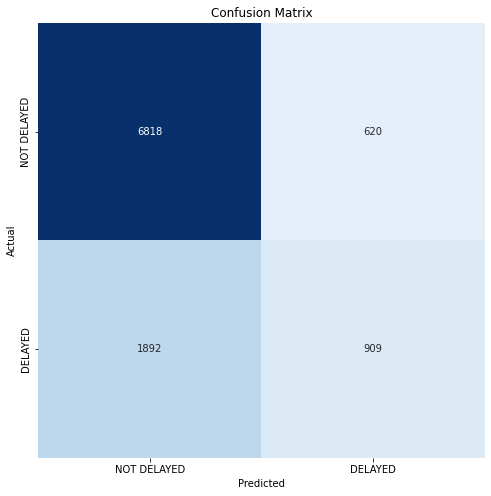

Classification Report:
----------------------
               precision    recall  f1-score   support

 NOT DELAYED       0.78      0.92      0.84      7438
     DELAYED       0.59      0.32      0.42      2801

    accuracy                           0.75     10239
   macro avg       0.69      0.62      0.63     10239
weighted avg       0.73      0.75      0.73     10239



In [32]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)
model_acc = model.score(X_valid, y_valid)
print("Test Accuracy: {:.2f}%".format(model_acc * 100))

y_true = np.array(y_valid)
y_pred = model.predict(X_valid)

cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=["NOT DELAYED", "DELAYED"])

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(2) + 0.5, ["NOT DELAYED", "DELAYED"])
plt.yticks(np.arange(2) + 0.5, ["NOT DELAYED", "DELAYED"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

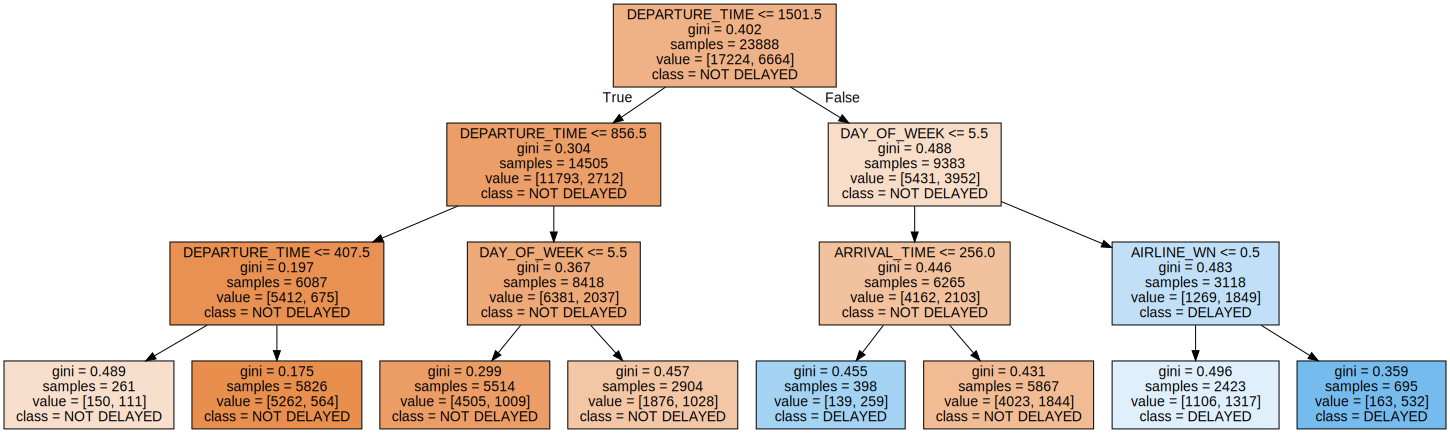

In [33]:
dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=["NOT DELAYED", "DELAYED"],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

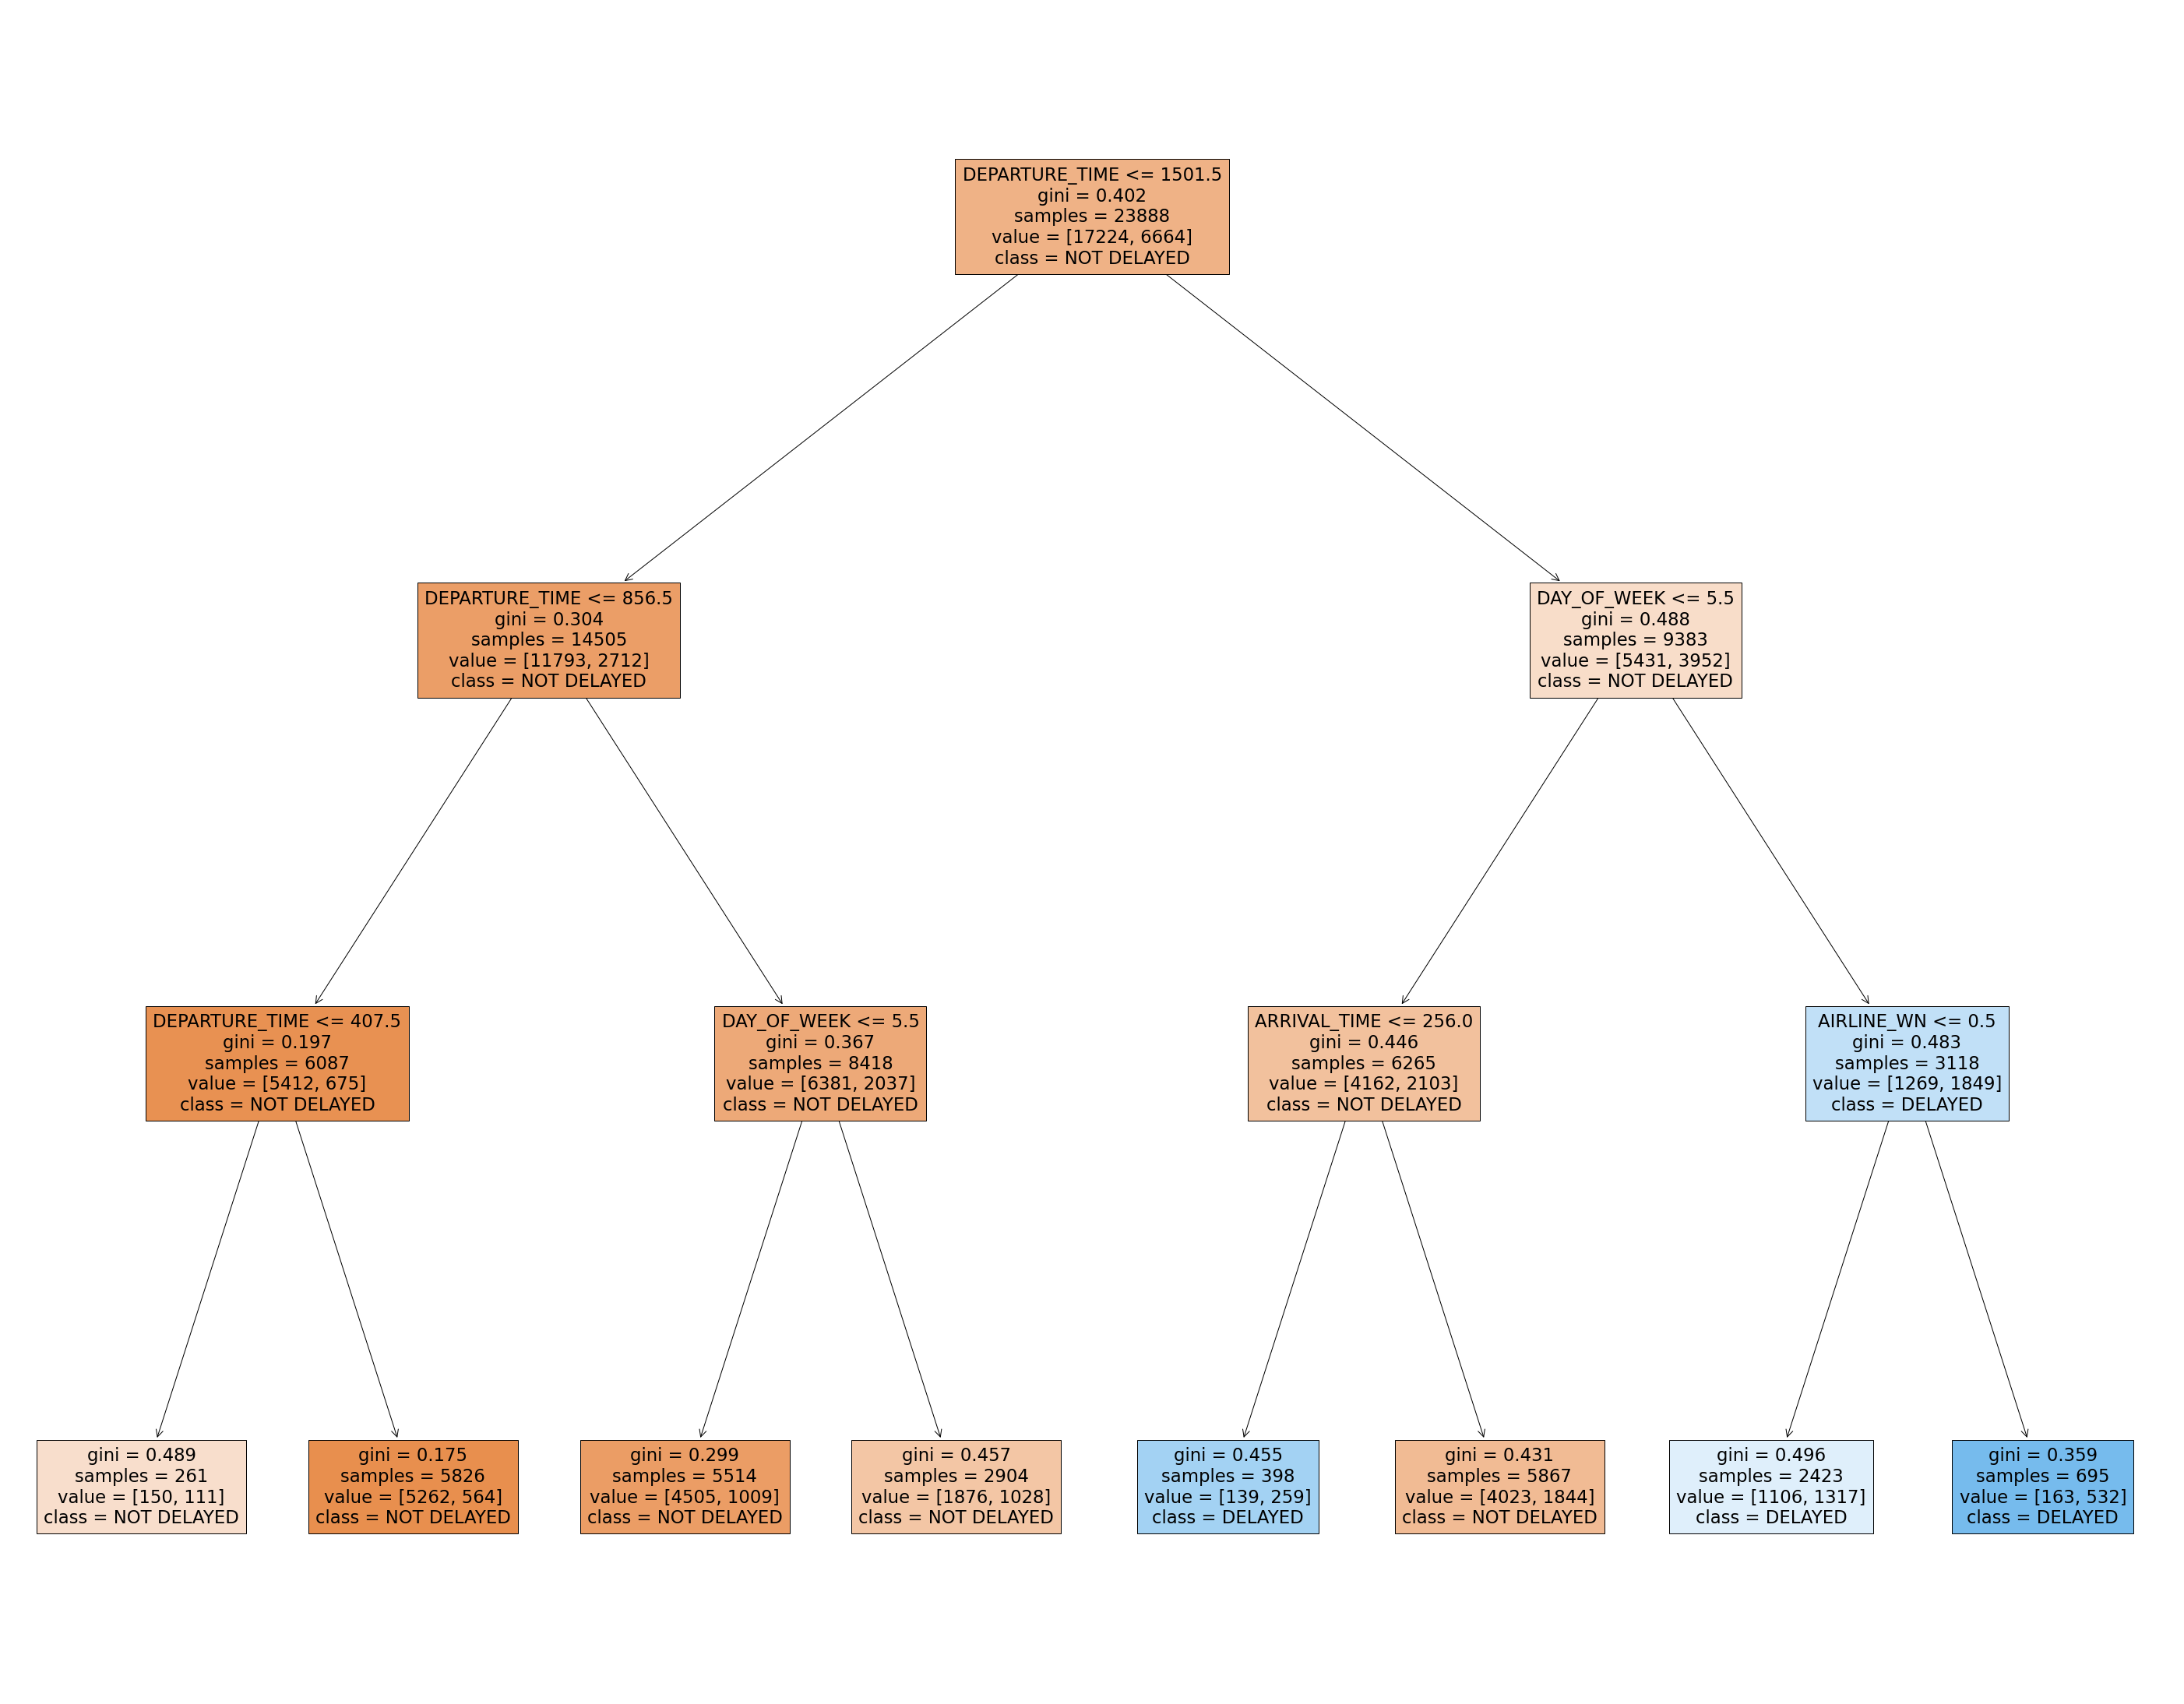

In [34]:
fig = plt.figure(figsize=(50,40))
_ = tree.plot_tree(model, 
                   feature_names=X_train.columns,  
                   class_names=["NOT DELAYED", "DELAYED"],
                   filled=True)

### Max depth performance

Text(0.5, 0, 'max depth')

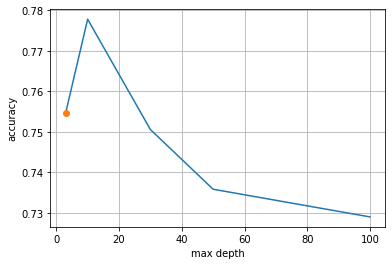

In [35]:
from sklearn.metrics import accuracy_score
max_depth_list = [3,10,30,50,100]

accuracy = []

for x in max_depth_list:
    dtc = DecisionTreeClassifier(max_depth=x) 
    dtc.fit(X_train, y_train)
    accuracy.append(dtc.score(X_valid, y_valid))

plt.plot(max_depth_list, accuracy) 
plt.plot(max_depth_list[0], accuracy[0], marker='o') 
plt.grid() #adds a grid to the plot
plt.ylabel('accuracy') #xlabel
plt.xlabel('max depth') #ylabel

We see a max depth = 10 as the best candidate, with significant drop off as the model becomes more complex. This an interesting find and exemplifies just how much the model the . We can then try and improve our dismal classification report by changing the depth and evaluating on the test data:

In [36]:
DT_regr = DecisionTreeClassifier(max_depth=10, random_state=369)
DT_model = DT_regr.fit(X_train,y_train)
DT_predictions = pd.DataFrame(DT_regr.predict(X_test))
print("MSE =", metrics.mean_squared_error(DT_predictions, y_test))
DT_accuracy = DT_model.score(X_test, y_test)
print('DT Accuracy on Test Set = '+ str(DT_accuracy.round(2)))

MSE = 0.23348830849172705
DT Accuracy on Test Set = 0.77


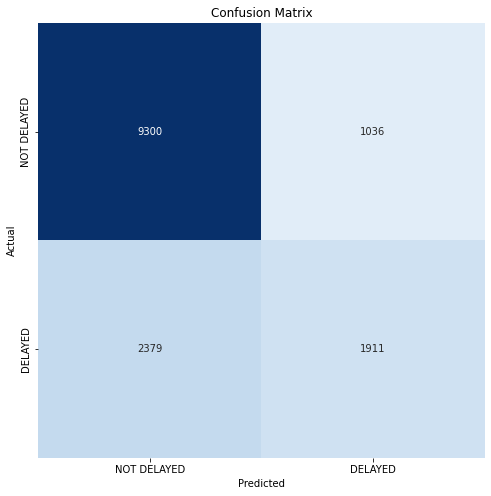

Classification Report:
----------------------
               precision    recall  f1-score   support

 NOT DELAYED       0.80      0.90      0.84     10336
     DELAYED       0.65      0.45      0.53      4290

    accuracy                           0.77     14626
   macro avg       0.72      0.67      0.69     14626
weighted avg       0.75      0.77      0.75     14626



In [37]:
y_true = np.array(y_test)
y_pred = DT_model.predict(X_test)
cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=["NOT DELAYED", "DELAYED"])

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(2) + 0.5, ["NOT DELAYED", "DELAYED"])
plt.yticks(np.arange(2) + 0.5, ["NOT DELAYED", "DELAYED"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

The classifier struggles with the problem at hand to a concerning extend. Low recall for the delayed classification indicates just how difficult it is to predict a delay - especially one longer than 15 minutes. Other kaggle notebooks floating around have performed high accuracies without introducing this constraint, likely indicating that there are extraneous factors that could influence a delay beyond an arbitrary measure of 15 minutes.

Either way, the model has utility at least in correctly positioning when a flight may not be delayed, but it seems like a large information on the 15+ delay itself may lie outside the scope. 

![We did our best](https://media.tenor.com/v_JlMF04DtcAAAAd/bender-futurama.gif)

### <a id='5'>Extra: Compare to LogReg</a> 
While we are here in the realm of interpretable classifiers, it would be remiss to not conduct a comparison with a logistic regression component for comparison. We do not need to tune the logistic regression, but only compare its classification report:

Test Accuracy: 77.31%


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


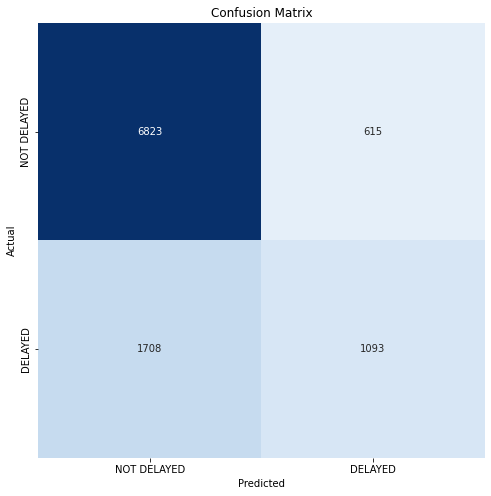

Classification Report:
----------------------
               precision    recall  f1-score   support

 NOT DELAYED       0.80      0.92      0.85      7438
     DELAYED       0.64      0.39      0.48      2801

    accuracy                           0.77     10239
   macro avg       0.72      0.65      0.67     10239
weighted avg       0.76      0.77      0.75     10239



In [38]:
#For the logistic regression model only, we will scale the data to improve performance. The DT is our interpetable model.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#Resplit data
y = df_pp_enc['DELAY'].copy()
X = df_pp_enc.drop('DELAY', axis=1).copy()

# X scale
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)
#Validation split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.7, random_state=0)



model = LogisticRegression()
model.fit(X_train, y_train)
model_acc = model.score(X_valid, y_valid)
print("Test Accuracy: {:.2f}%".format(model_acc * 100))

y_true = np.array(y_valid)
y_pred = model.predict(X_valid)

cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=["NOT DELAYED", "DELAYED"])

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(2) + 0.5, ["NOT DELAYED", "DELAYED"])
plt.yticks(np.arange(2) + 0.5, ["NOT DELAYED", "DELAYED"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

The logistic regressor is even worse when it comes to accurately identifiying a delay, and this is obvious from the very low recall score for the delayed classification. It would seem that decision trees remain the most interpretable and versatile tool for this classification problem with the given constraint.